**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Train and Evaluate Model](#2-bullet)
3. [Predictions](#3-bullet)

## 1. [Libraries and settings](#1-bullet)

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.preprocessing import StandardScaler

import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('LCS DATASET PATH', sep='\t', index_col=0)

In [144]:
df['TradingDate'] = pd.to_datetime(df['TradingDate'], format='%Y-%m-%d')

In [145]:
df = df.dropna()

In [146]:
# Create a new dataframe
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values

In [147]:
# scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

In [148]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [149]:
time_step = 30
x_for_train, y_for_train = create_dataset(scaled_data, time_step)

x_for_train = x_for_train.reshape(x_for_train.shape[0],x_for_train.shape[1])
y_for_train = y_for_train.reshape(y_for_train.shape[0],1)

In [150]:
training_size=int(len(dataset)*0.8)
test_size=len(dataset)-training_size
train_data,test_data=scaled_data[0:training_size],scaled_data[training_size:len(dataset)]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2829, 1)
test_data:  (708, 1)


In [151]:
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1])
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)


print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test", y_test.shape)

x_train:  (2798, 30)
y_train:  (2798, 1)
x_test:  (677, 30)
y_test (677, 1)


### Building model

Using best hyperparameters after tuning to retrain model

In [152]:
# Create and train the SVR model
eval_set = [(x_test, y_test)]
XgB_model = XGBRegressor(learning_rate= 0.01, max_depth = 10, n_estimators = 500)
XgB_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [153]:
predictions = XgB_model.predict(x_test)
predictions = predictions.reshape(-1,1)

predictions_train = XgB_model.predict(x_train)
predictions_train = predictions_train.reshape(-1,1)

In [154]:
predictions = scaler.inverse_transform(predictions)
predictions_train = scaler.inverse_transform(predictions_train)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [155]:
column_names_pred = ['Close_predict']
df_predictions = pd.DataFrame(predictions, columns=column_names_pred)

column_names_test = ['Close_test']
df_test = pd.DataFrame(y_test, columns=column_names_test)

concatenated = np.concatenate([df_predictions, df_test], axis=1)
column_names_concat = ['Close_predict', 'Close_test']
df_concatenated = pd.DataFrame(concatenated, columns = column_names_concat)

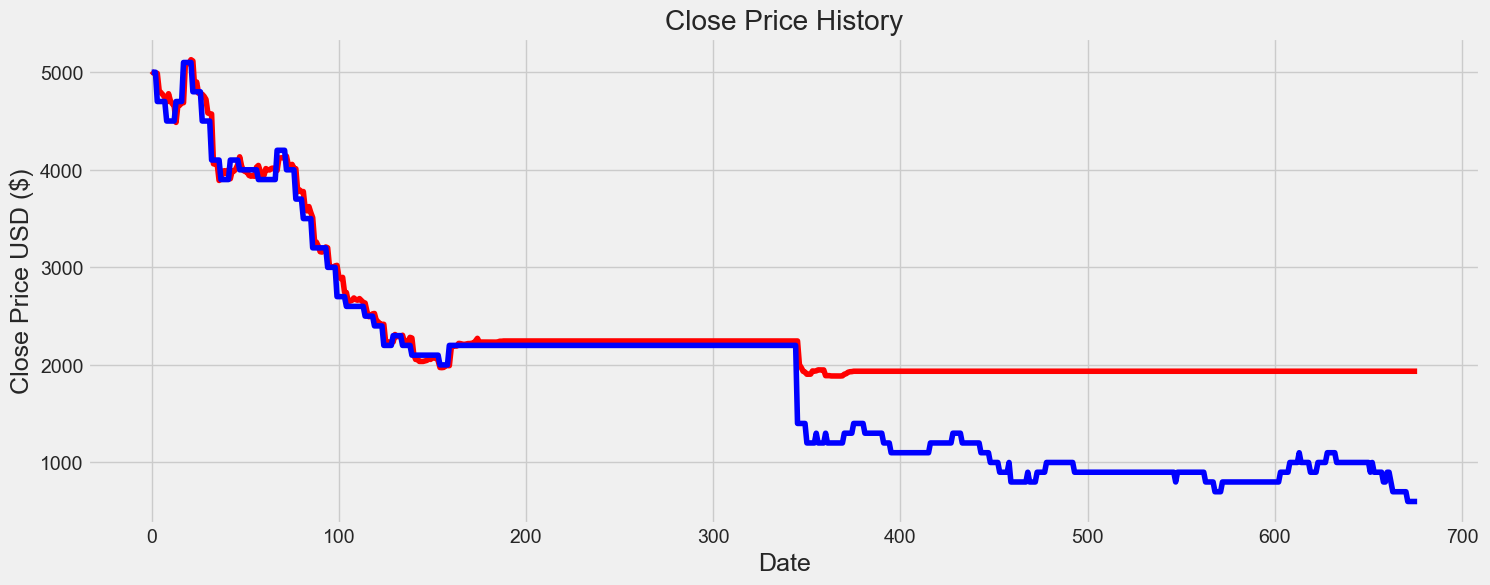

In [156]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df_predictions['Close_predict'], color='red', label='Predicted Close Price')
plt.plot(df_test['Close_test'], color='blue', label='Actual Close Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

### Evaluate model

In [157]:
predictions = scaler.fit_transform(predictions)
predictions_train = scaler.fit_transform(predictions_train)
y_test = scaler.fit_transform(y_test)
y_train = scaler.fit_transform(y_train)

In [158]:

mae_train = mean_absolute_error(y_train, predictions_train)
rmse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", rmse_train)
print("Train R-squared:", r2_train)

Train Mean Absolute Error: 0.011188745411523333
Train Mean Squared Error: 0.0002978006724533847
Train R-squared: 0.9997021993275467


In [159]:
mae_test = mean_absolute_error(y_test, predictions)
rmse_test = mean_squared_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)

print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", rmse_test)
print("Test R-squared:", r2_test)

Test Mean Absolute Error: 0.33423814707521576
Test Mean Squared Error: 0.13852820123436693
Test R-squared: 0.8614717987656331


## 3. [Predictions](#3-bullet)

In [160]:
predictions = scaler.inverse_transform(predictions)
predictions_train = scaler.inverse_transform(predictions_train)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [161]:
last_60_days = np.array([y_test[i] for i in range(-1, -61, -1)])
next_days = []  
for i in range(60):
    input_data = x_test[i-60].reshape(-1,30)

    predicted_price = XgB_model.predict(input_data)
    next_days.append(predicted_price)

#     
# pop_price = next_days.pop(0)
print("Predicted prices for the next days:")
    
for i, price in enumerate(next_days):
    price = scaler.inverse_transform(price.reshape(-1,1))
    print(f"Day {i+1}: {price}")
    
next_days = scaler.inverse_transform(np.array(next_days).reshape(-1,1))

Predicted prices for the next days:
Day 1: [[2586.6724]]
Day 2: [[2586.6724]]
Day 3: [[2586.6724]]
Day 4: [[2586.6724]]
Day 5: [[2586.6724]]
Day 6: [[2586.6724]]
Day 7: [[2586.6724]]
Day 8: [[2586.6724]]
Day 9: [[2586.6724]]
Day 10: [[2586.6724]]
Day 11: [[2586.6724]]
Day 12: [[2586.6724]]
Day 13: [[2586.6724]]
Day 14: [[2586.6724]]
Day 15: [[2586.6724]]
Day 16: [[2586.6724]]
Day 17: [[2586.6724]]
Day 18: [[2586.6724]]
Day 19: [[2586.6724]]
Day 20: [[2586.6724]]
Day 21: [[2586.6724]]
Day 22: [[2586.6724]]
Day 23: [[2586.6724]]
Day 24: [[2586.6724]]
Day 25: [[2586.6724]]
Day 26: [[2586.6724]]
Day 27: [[2586.6724]]
Day 28: [[2586.6724]]
Day 29: [[2586.6724]]
Day 30: [[2586.6724]]
Day 31: [[2586.6724]]
Day 32: [[2586.6724]]
Day 33: [[2586.6724]]
Day 34: [[2586.6724]]
Day 35: [[2586.6724]]
Day 36: [[2586.6724]]
Day 37: [[2586.6724]]
Day 38: [[2586.6724]]
Day 39: [[2586.6724]]
Day 40: [[2586.6724]]
Day 41: [[2586.6724]]
Day 42: [[2586.6724]]
Day 43: [[2586.6724]]
Day 44: [[2586.6724]]
Day 4

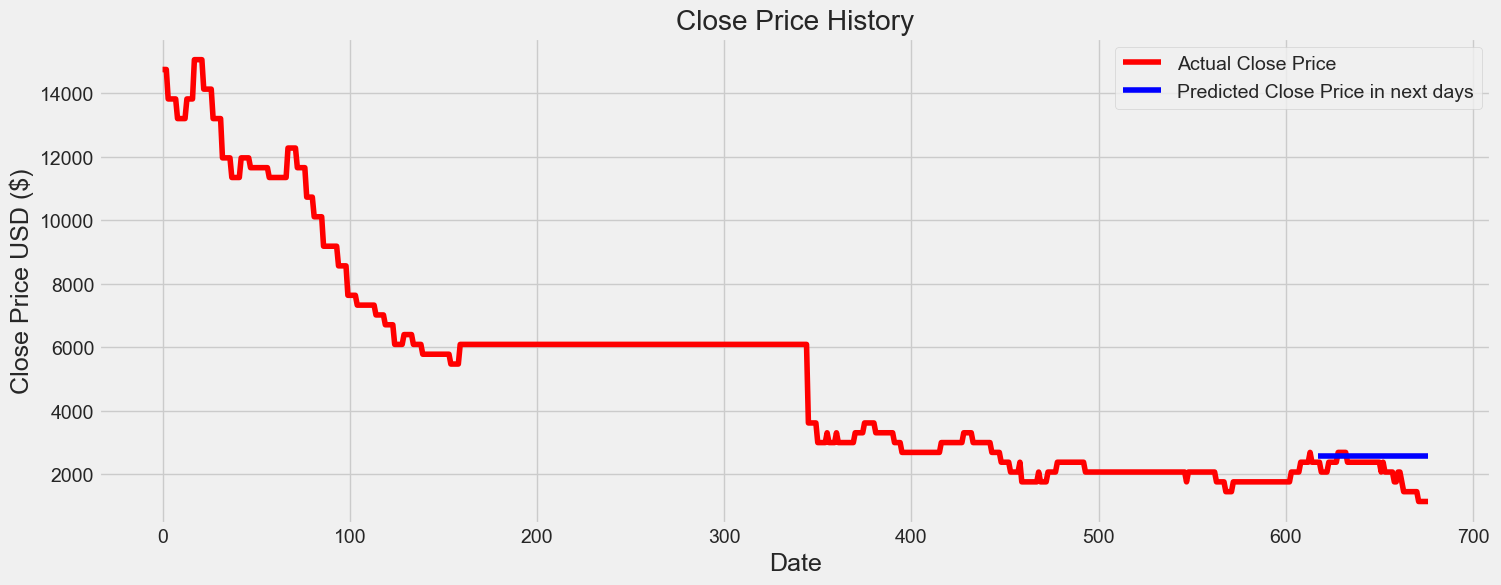

In [162]:
plt.figure(figsize=(16, 6))
plt.title('Close Price History')
plt.plot(y_test[:], color='red', label='Actual Close Price')
plt.plot(range(len(y_test)-60, len(y_test)), next_days, color='blue', label='Predicted Close Price in next days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()